In [1]:
import os

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
analyze_path = os.path.join(parent_dir, "utils")

os.chdir(analyze_path)

要先建立輸入到模型的資料
- 若是要分類是否是熱點，應該要以一個區域的grid為單位
- 所以建立得grid亦包含該地區的所有特徵資料，以比例顯示

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = ['Arial Unicode Ms']
# plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']

from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
from utils_model import eval_loop, to_tensors
from utils import read_data, read_taiwan_specific

## obtain hotspot's county
這段使用將grid依照geometry找出個別在哪個城市

In [3]:
taiwan, grid_filter = read_taiwan_specific(read_grid=True)

In [4]:
# all_featuresV2 為將離群替換為中位數
all_features_df = pd.read_csv("../ComputedDataV2/ForModel/all_featuresV1.csv")

# 移除高共線
cols = all_features_df.columns[all_features_df.columns.str.contains('事故位置大類別名稱')]
cols2 = all_features_df.columns[all_features_df.columns.str.contains('號誌動作')]
cols3 = all_features_df.columns[all_features_df.columns.str.contains('original_speed')]
all_features_df.drop(columns=cols, inplace=True)
all_features_df.drop(columns=cols2, inplace=True)
all_features_df.drop(columns=cols3, inplace=True)

### Model Preprocess

In [10]:
# with county town
# 原始資料index並非從1開始所以需reset
new_grid = pd.concat([grid_filter[['COUNTYNAME']], all_features_df], axis=1)
county_dummies = pd.get_dummies(new_grid['COUNTYNAME'], prefix='county')
new_grid_encoded = pd.concat([new_grid.drop(['COUNTYNAME'], axis=1), county_dummies], axis=1)

# binary hotspot
new_grid_encoded['hotspot'] = new_grid_encoded['hotspot'].apply(lambda x: 'Hotspot' if 'Hotspot' in str(x) else 'Not Hotspot')
le = LabelEncoder()
# y = le.fit_transform(new_grid_encoded['hotspot'])
y = new_grid_encoded['hotspot'].map({'Not Hotspot': 0, 'Hotspot': 1}).values
X = new_grid_encoded.drop(columns=['hotspot'])
le.classes_ = ['Not Hotspot', 'Hotspot']

# interaction
from utils_model import get_interaction
X = get_interaction(X)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
y_train = pd.Series(y_train, index=X_train.index)
y_test  = pd.Series(y_test,  index=X_test.index)

# undersampling
cls_counts = y_test.value_counts()
min_count = cls_counts.min()
rus_test = RandomUnderSampler(
    sampling_strategy={int(c): int(min_count) for c in cls_counts.index},
    random_state=42
)
X_resampled_test, y_resampled_test = rus_test.fit_resample(X_test, y_test)

/Users/wangqiqian/opt/anaconda3/envs/ST-RTA/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/wangqiqian/opt/anaconda3/envs/ST-RTA/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


# LR and RF

In [11]:
from sklearn.model_selection import GridSearchCV

param_grid_lr = {
    'penalty': ['elasticnet'],
    'solver': ['saga'],
    'l1_ratio': [0.1, 0.5, 0.9],
    'C': [0.01, 0.1, 1, 10]
}

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 2, 5]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [12]:
# lr = GridSearchCV(
#     LogisticRegression(
#         penalty='elasticnet', solver='saga',
#         class_weight='balanced', max_iter=1000, 
#         random_state=42, multi_class='multinomial'
#     ),
#     param_grid=param_grid_lr,
#     cv=cv,
#     scoring='roc_auc',
#     n_jobs=-1
# )
# rf = GridSearchCV(
#     RandomForestClassifier(
#         class_weight='balanced', random_state=42
#     ),
#     param_grid=param_grid_rf,
#     cv=cv,
#     scoring='roc_auc',
#     n_jobs=-1
# )

lr = LogisticRegression(
        penalty='elasticnet', solver='saga', l1_ratio=0.5,
        class_weight='balanced', max_iter=1000, 
        random_state=42, 
        multi_class='multinomial',
        n_jobs=-1
    )
rf = RandomForestClassifier(
        n_estimators=300, max_depth=None, min_samples_leaf=1,
        class_weight='balanced', n_jobs=-1, random_state=42,
    )

for name, clf in [('Logistic', lr), ('RandomForest', rf)]:
    scores = cross_val_score(clf, X_train, y_train, cv=cv, n_jobs=-1,
                            # scoring='roc_auc_ovr_weighted',
                            scoring='roc_auc'
                             )
    print(f'{name} CV ROC AUC: {scores.mean():.3f} ± {scores.std():.3f}')

lr.fit(X_train, y_train)
rf.fit(X_train, y_train)

proba_test_lr = lr.predict_proba(X_resampled_test)
proba_test_rf = rf.predict_proba(X_resampled_test)
y_pred_lr = np.argmax(proba_test_lr, axis=1)
y_pred_rf = np.argmax(proba_test_rf, axis=1)

/Users/wangqiqian/opt/anaconda3/envs/ST-RTA/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/wangqiqian/opt/anaconda3/envs/ST-RTA/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/wangqiqian/opt/anaconda3/envs/ST-RTA/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, bin

Logistic CV ROC AUC: 0.868 ± 0.003
RandomForest CV ROC AUC: 0.896 ± 0.001


/Users/wangqiqian/opt/anaconda3/envs/ST-RTA/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


In [13]:
import joblib

joblib.dump(lr, '../ComputedDataV2/ModelPerformance/lr_modelV1.pkl')
joblib.dump(rf, '../ComputedDataV2/ModelPerformance/rf_modelV1.pkl')

# # load model
# lr = joblib.load('../ComputedDataV2/ModelPerformance/lr_modelV1.pkl')
# rf = joblib.load('../ComputedDataV2/ModelPerformance/rf_modelV1.pkl')

proba_test_lr = lr.predict_proba(X_resampled_test)
proba_test_rf = rf.predict_proba(X_resampled_test)
y_pred_lr = np.argmax(proba_test_lr, axis=1)
y_pred_rf = np.argmax(proba_test_rf, axis=1)

In [14]:
from utils_model import print_results

# print_results(proba_test_lr, le.classes_, y_resampled_test)
print_results(proba_test_lr, le.classes_, y_resampled_test)
print_results(proba_test_rf, le.classes_, y_resampled_test)

Confusion Matrix
[[3631 1131]
 [ 846 3916]]
Classification Report
              precision    recall  f1-score   support

 Not Hotspot      0.811     0.762     0.786      4762
     Hotspot      0.776     0.822     0.798      4762

    accuracy                          0.792      9524
   macro avg      0.793     0.792     0.792      9524
weighted avg      0.793     0.792     0.792      9524

ROC AUC: 0.867
PR  AUC macro: 0.842
PR  AUC wighted: 0.842
Confusion Matrix
[[4477  285]
 [1894 2868]]
Classification Report
              precision    recall  f1-score   support

 Not Hotspot      0.703     0.940     0.804      4762
     Hotspot      0.910     0.602     0.725      4762

    accuracy                          0.771      9524
   macro avg      0.806     0.771     0.764      9524
weighted avg      0.806     0.771     0.764      9524

ROC AUC: 0.894
PR  AUC macro: 0.897
PR  AUC wighted: 0.897


設施平均：該地區的事故點附近平均會有幾個設施

### RandomForest Feature Importance & LinearRegression coefficient
- group的寫法可能還要再修

In [15]:
def get_importance(model, df, specific_col=None):
    if model.__class__.__name__ == 'LogisticRegression':
        # coefs = model.coef_[0]
        # importances = np.abs(coefs)
        importances = model.coef_[0]
    else:
        importances = model.feature_importances_

    feature_names = df.columns

    if specific_col:
        sel_idx = [i for i, name in enumerate(feature_names) if specific_col in name]
        indices = np.argsort(importances[sel_idx])[::-1]
        indices = [sel_idx[i] for i in indices] # 對應回原始 index
    else:
        indices = np.argsort(importances)[::-1]

    # 整合整個欄位為一個重要性
    importance_ungrouped = {}
    for i in indices:
        # 直接group importance不可做exp，他並不代表勝算比
        importance_ungrouped[feature_names[i]] = [importances[i], np.exp(importances[i])]
        # importance_ungrouped[feature_names[i]] = [importances[i], importances[i]]

    fi_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    fi_df['main_feature'] = fi_df['feature'].str.split('_').str[0]
    grouped = fi_df.groupby('main_feature', as_index=False)['importance'].sum()
    grouped['exp'] = np.exp(grouped['importance'])
    grouped = grouped.sort_values('importance', ascending=False)

    return importance_ungrouped, grouped

importance_rf, importance_grouped_rf = get_importance(rf, X_train)
importance_lr, importance_grouped_lr = get_importance(lr, X_train)

In [16]:
def build_structured_county(importance):
    """
    importance: dict, 例如 {"特徵A x county_臺北市": [coef, OR], ...}
    """
    out = {}

    for name, v in importance.items():
        # 跳過純縣市 dummy，如 "county_臺北市"
        if name.startswith("county_") and " x county_" not in name:
            continue
        # 只處理有交互字樣的
        if " x county_" not in name:
            continue

        base, county_tag = name.split(" x county_", 1)  # base 特徵名、county_tag 縣市名（不含前綴）

        out.setdefault(county_tag, {})[base] = v[1]

    return out

structured_all = build_structured_county(importance_lr)
structured_all = pd.DataFrame(structured_all)
structured_all

臺中市       臺北市       南投縣       臺南市  \
速限-第1當事者_mean                          5.421938  4.277615  1.387232  0.871587   
道路類別-第1當事者-名稱_專用道路                     1.512760  1.625480  1.000000  1.000000   
parkinglot_100m_count_mean             1.432524  1.000000  1.000000  1.000000   
道路類別-第1當事者-名稱_其他                       1.407021  1.000000  1.000000  1.970788   
車道劃分設施-分向設施大類別名稱_中央分向島                 1.302183  1.087278  1.455182  0.825105   
車道劃分設施-分道設施-快慢車道間名稱_窄式快慢車道分隔島(無柵欄)     1.178995  0.423720  1.000000  0.480624   
道路類別-第1當事者-名稱_快速(公)道                   1.139289       NaN  1.000000  1.000000   
道路型態大類別名稱_單路部分                         1.127918  0.591364  0.793036  1.265819   
車道劃分設施-分向設施大類別名稱_無                     1.126515  1.668346  0.679230  1.171682   
車道劃分設施-分道設施-快車道或一般車道間名稱_車道線(無標記)       1.115180  1.106686  0.873767  0.972815   
車輛撞擊部位大類別名稱-最初_汽車                      1.086674  1.000000  0.898065  1.050418   
youbike_100m_count_mean                1.069958  0.493680       NaN  1.158689   
車道劃分設施-分道設施-快車道或一般車道間名稱_未繪設車道線         1.054889  0.810400  1.000000  0.910239   
號誌-號誌種類名稱_無號誌                          1.042269  1.618023  0.875733  0.963808   
事故類型及型態大類別名稱_車與車                       1.014965  1.000000  1.000000  1.000000   
車道劃分設施-分道設施-路面邊線名稱_無                   1.000000  1.000000  1.000000  1.000000   
車道劃分設施-分道設施-快慢車道間名稱_快慢車道分隔線            1.000000  1.103025  0.703141  1.358471   
車道劃分設施-分道設施-快慢車道間名稱_窄式快慢車道分隔島(附柵欄)     1.000000  1.000000  1.000000  1.170134   
號誌-號誌種類名稱_行車管制號誌                       1.000000  1.557210  0.954137  1.000000   
道路型態大類別名稱_其他                           1.000000  1.000000  2.179792  1.000000   
道路型態大類別名稱_平交道                          1.000000       NaN       NaN  1.000000   
道路型態大類別名稱_圓環廣場                         1.000000  1.000000       NaN       NaN   
車道劃分設施-分向設施大類別名稱_雙向禁止超車線               1.000000  0.428077  1.201606  1.000000   
道路類別-第1當事者-名稱_省道                       1.000000       NaN  3.510829  0.382270   
mrt_100m_count_mean                    1.000000  1.000000       NaN       NaN   
道路類別-第1當事者-名稱_村里道路                     1.000000  1.632868  2.180316  1.172042   
道路類別-第1當事者-名稱_鄉道                       1.000000  1.000000  0.761968  0.592047   
車輛撞擊部位大類別名稱-最初_機車與自行車                  1.000000  0.820954  1.085896  1.000000   
事故類型及型態大類別名稱_平交道事故                     1.000000       NaN       NaN  1.000000   
事故類型及型態大類別名稱_人與車                       1.000000  1.000000  1.000000  0.611903   
車輛撞擊部位大類別名稱-最初_其他                      0.971794  0.868890  1.173586  1.000000   
事故類型及型態大類別名稱_車輛本身                      0.971212  1.814761  1.056703  1.000000   
道路類別-第1當事者-名稱_市區道路                     0.960716  0.782141  1.488104  1.519343   
車道劃分設施-分向設施大類別名稱_行車分向線                 0.931451  1.000000  0.808801  0.894087   
道路類別-第1當事者-名稱_縣道                       0.929989  1.000000  0.682028  0.296598   
車道劃分設施-分道設施-快車道或一般車道間名稱_禁止變換車道線(無標記)   0.917377  1.000000  1.041515  0.788487   
車道劃分設施-分道設施-快慢車道間名稱_未繪設快慢車道分隔線         0.902308  1.000000  1.000000  1.000000   
車道劃分設施-分道設施-快車道或一般車道間名稱_禁止變換車道線(附標記)   0.900847  0.512303  1.420361  1.669362   
號誌-號誌種類名稱_閃光號誌                         0.897556  0.891334  1.187783  0.841355   
道路型態大類別名稱_交岔路                          0.884046  1.059627  1.000000  0.952104   
道路類別-第1當事者-名稱_國道                       0.870531  0.445509  0.860948  1.802363   
車道劃分設施-分道設施-快車道或一般車道間名稱_車道線(附標記)       0.824294  1.591381  0.674248  1.364635   
車道劃分設施-分道設施-快慢車道間名稱_寬式快慢車道分隔島(50公分以上)  0.815604  1.754909  1.446107  0.850135   
號誌-號誌種類名稱_行車管制號誌(附設行人專用號誌)             0.807222  0.490492  1.628494  3.373003   
車道劃分設施-分道設施-路面邊線名稱_有                   0.676391  1.012718  1.120776  0.972848   
車道劃分設施-分向設施大類別名稱_單向禁止超車線               0.312435  0.825687  1.000000  1.000000   

                                            桃園市       彰化縣       臺東縣       宜蘭縣  \
速限-第1當事者_mean                          1.323201  2.050234  1.000000  0.226793   
道路類別-第1當事者-名稱_專用道路                     1.000000  1.000000  1.000000  1.000

In [17]:
from config import col_translation, countycity_dct
odds_df = structured_all[['臺北市', '新北市', '臺中市', '高雄市', '臺東縣', '花蓮縣']]

odds_df.sort_values(by='臺北市', ascending=False)
odds_df = odds_df.rename(columns=countycity_dct, index=col_translation)

## Odds Ratio

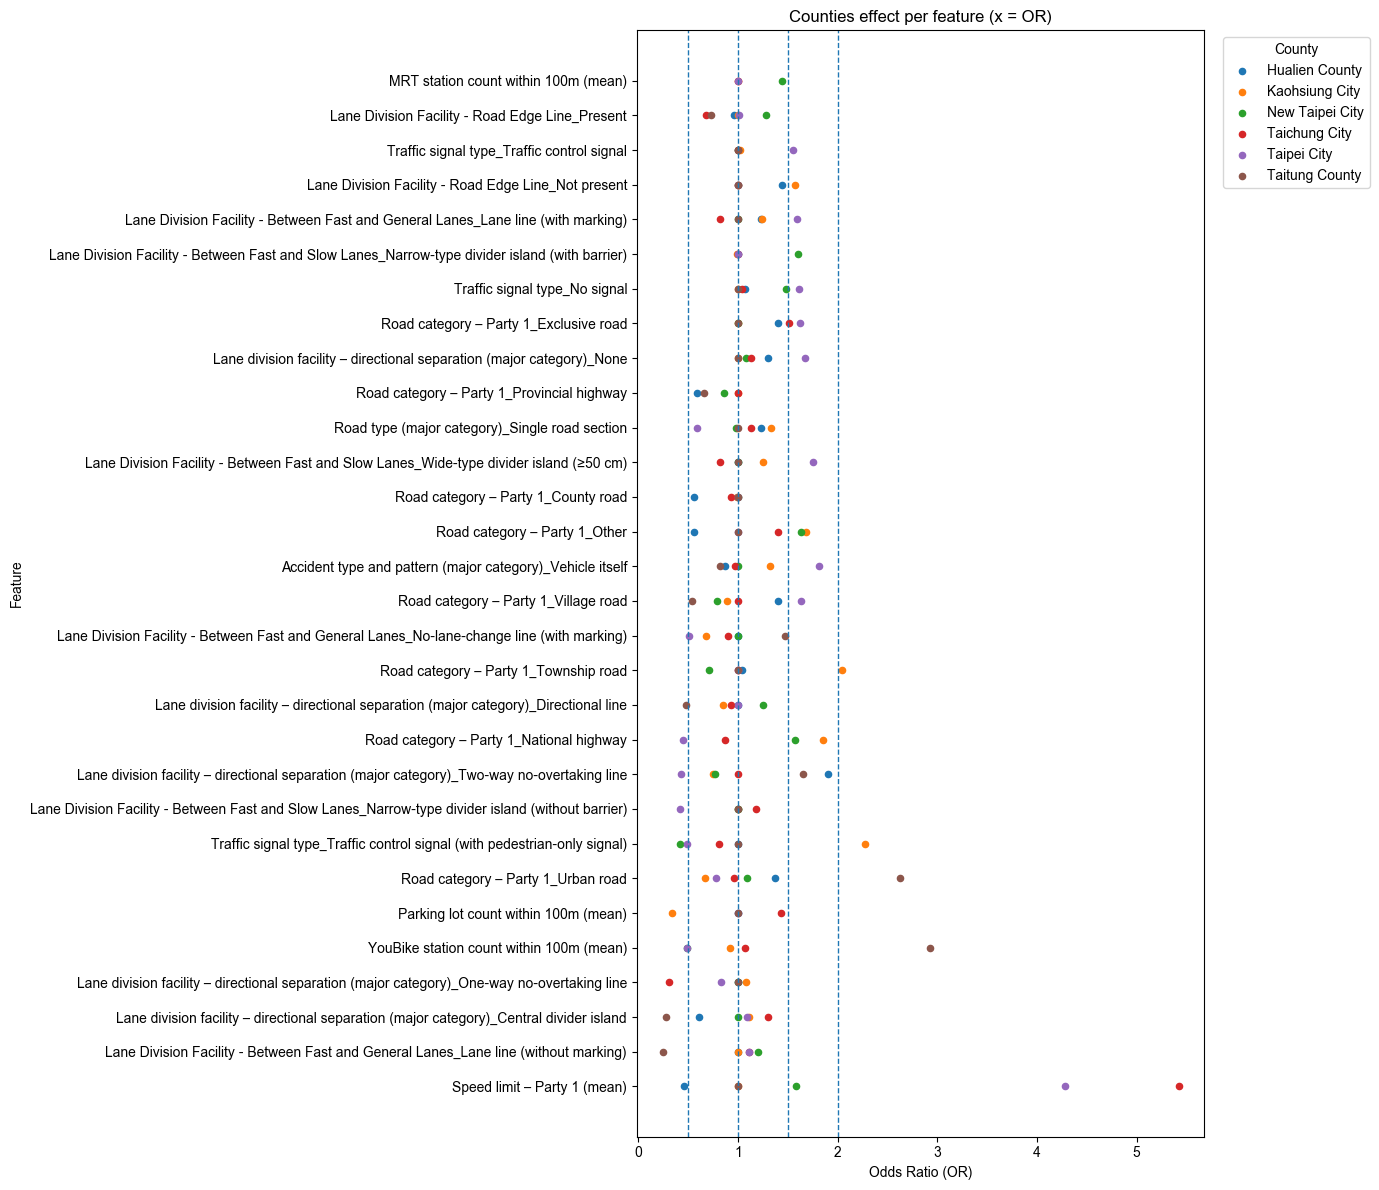

In [18]:
plt.rcParams['font.family'] = ['Arial Unicode Ms']

df_long = odds_df.stack().reset_index()
df_long.columns = ['feature', 'county', 'value']

# 用 max|ln(OR)| 當排序依據，抓前 top_k 個以免圖太擁擠
# 用 OR 排序會忽略小於 1 的強負向特徵
top_k = 30
rank = (
    df_long.assign(abs_log=lambda d: np.abs(np.log(d['value'])))
           .groupby('feature')['abs_log'].max()
           .sort_values(ascending=False)
)
feat_sel = rank.head(top_k).index
plot_data = df_long[df_long['feature'].isin(feat_sel)]

features = plot_data['feature'].dropna().unique().tolist()
features = [f for f in rank.index if f in features]  # 用上面 rank 的順序
ypos = {f: i for i, f in enumerate(features)}

plt.figure(figsize=(14, max(6, 0.4*len(features))))
plt.axvline(1.0, linestyle='--', linewidth=1)
plt.axvline(1.5, linestyle='--', linewidth=1)
plt.axvline(0.5, linestyle='--', linewidth=1)
plt.axvline(2, linestyle='--', linewidth=1)

for county, d in plot_data.groupby('county'):
    y = [ypos[f] for f in d['feature']]
    plt.scatter(d['value'], y, s=20, label=county)

plt.yticks(range(len(features)), features)
plt.xlabel('Odds Ratio (OR)')
plt.ylabel('Feature')
plt.title('Counties effect per feature (x = OR)')
plt.legend(title='County', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Neural Network

In [19]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
INPUT_DIM = X_resampled_test.shape[1]
NUM_CLASSES = 2

class BinaryMLP(nn.Module):
    def __init__(self, in_dim=INPUT_DIM, num_classes=NUM_CLASSES, drop=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 1024),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Linear(64, num_classes)  # logits
        )
    def forward(self, x):
        return self.net(x)

In [20]:
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

X_train_t, y_train_t = to_tensors(X_train, y_train)
X_val_t, y_val_t = to_tensors(X_val_nn, y_val_nn)
X_test_t, y_test_t = to_tensors(X_resampled_test, y_resampled_test)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=256, shuffle=True, drop_last=False)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=512, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=512, shuffle=False)

model = BinaryMLP().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

best_val = -np.inf
patience = 5
wait = 0
epochs = 20

In [21]:
for epoch in range(1, epochs+1):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)

    train_loss = total_loss / len(train_loader.dataset)
    val_metrics = eval_loop(model, val_loader, le)
    print(f'Epoch {epoch:02d}/{epochs} | loss {train_loss:.4f} | '
          f'val_acc {val_metrics["acc"]:.3f} | val_f1 {val_metrics["f1"]:.3f} | val_auc {val_metrics["auc"]:.3f}')

    score_for_early = val_metrics["auc"]  # 你也可用 f1
    if score_for_early > best_val:
        best_val = score_for_early
        wait = 0
        # torch.save(model.state_dict(), 'best_model.pt')
    else:
        wait += 1
        if wait >= patience:
            print('Early stopping.')
            break

Epoch 01/20 | loss 0.3634 | val_acc 0.862 | val_f1 0.687 | val_auc 0.907
Epoch 02/20 | loss 0.3260 | val_acc 0.869 | val_f1 0.690 | val_auc 0.913
Epoch 03/20 | loss 0.3162 | val_acc 0.874 | val_f1 0.717 | val_auc 0.918
Epoch 04/20 | loss 0.3095 | val_acc 0.872 | val_f1 0.686 | val_auc 0.921
Epoch 05/20 | loss 0.3031 | val_acc 0.873 | val_f1 0.685 | val_auc 0.924
Epoch 06/20 | loss 0.2962 | val_acc 0.881 | val_f1 0.733 | val_auc 0.929
Epoch 07/20 | loss 0.2926 | val_acc 0.882 | val_f1 0.741 | val_auc 0.934
Epoch 08/20 | loss 0.2856 | val_acc 0.885 | val_f1 0.731 | val_auc 0.936
Epoch 09/20 | loss 0.2790 | val_acc 0.890 | val_f1 0.750 | val_auc 0.941
Epoch 10/20 | loss 0.2736 | val_acc 0.891 | val_f1 0.748 | val_auc 0.943
Epoch 11/20 | loss 0.2686 | val_acc 0.893 | val_f1 0.755 | val_auc 0.944
Epoch 12/20 | loss 0.2639 | val_acc 0.894 | val_f1 0.759 | val_auc 0.947
Epoch 13/20 | loss 0.2575 | val_acc 0.898 | val_f1 0.775 | val_auc 0.952
Epoch 14/20 | loss 0.2523 | val_acc 0.901 | val_f1 

In [ ]:
# model = BinaryMLP().to(device)
# model.load_state_dict(torch.load('../ComputedDataV2/ModelPerformance/nn_modelV1.pth'))

test_metrics = eval_loop(model, test_loader, le)
print(test_metrics['report'])

# torch.save(model.state_dict(), '../ComputedDataV2/ModelPerformance/nn_modelV1.pth')

              precision    recall  f1-score   support

 Not Hotspot      0.733     0.918     0.815      4762
     Hotspot      0.890     0.666     0.762      4762

    accuracy                          0.792      9524
   macro avg      0.811     0.792     0.788      9524
weighted avg      0.811     0.792     0.788      9524



## Permutation

In [24]:
from utils_model import build_groups_from_prefix, build_groups_with_interactions, build_pair_interaction_groups, PI_ML, PI_NN

groups = build_groups_with_interactions(X_test.columns)

print('lr')
base_lr, perm_lr = PI_ML(lr, X_test, y_test, groups=groups, n_repeats=10)
print('rf') 
base_rf, perm_rf = PI_ML(rf, X_test, y_test, groups=groups, n_repeats=10)
print('nn')
base_nn, perm_nn = PI_NN(model, X_test, y_test, groups=groups, n_repeats=10)

lr


/Users/wangqiqian/opt/anaconda3/envs/ST-RTA/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/wangqiqian/opt/anaconda3/envs/ST-RTA/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/wangqiqian/opt/anaconda3/envs/ST-RTA/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/wangqiqian/opt/anaconda3/envs/ST-RTA/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/wangqiqian/opt/anaconda3/envs/ST-RTA/lib/python3.9/site-packages/sklearn/utils/validation

rf


/Users/wangqiqian/opt/anaconda3/envs/ST-RTA/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/wangqiqian/opt/anaconda3/envs/ST-RTA/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/wangqiqian/opt/anaconda3/envs/ST-RTA/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/wangqiqian/opt/anaconda3/envs/ST-RTA/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/wangqiqian/opt/anaconda3/envs/ST-RTA/lib/python3.9/site-packages/sklearn/

nn


In [25]:
perm_lr.to_csv('../ComputedDataV2/Permutation/perm_lrV1.csv')
perm_rf.to_csv('../ComputedDataV2/Permutation/perm_rfV1.csv')
perm_nn.to_csv('../ComputedDataV2/Permutation/perm_nnV1.csv')

perm_lr = pd.read_csv('../ComputedDataV2/Permutation/perm_lrV1.csv')
perm_rf = pd.read_csv('../ComputedDataV2/Permutation/perm_rfV1.csv')
perm_nn = pd.read_csv('../ComputedDataV2/Permutation/perm_nnV1.csv')

In [26]:
group_translation = {
    "道路類別-第1當事者-名稱": "Road category – Party 1",
    "速限-第1當事者": "Speed limit – Party 1",
    "號誌-號誌種類名稱": "Traffic signal type",
    "車道劃分設施-分向設施大類別名稱": "Lane division facility – directional separation (major category)",
    "車輛撞擊部位大類別名稱-最初": "Vehicle impact location (major category, initial)",
    "county": "County",
    "車道劃分設施-分道設施-快車道或一般車道間名稱": "Lane Division Facility - Between Fast and General Lanes",
    "車道劃分設施-分道設施-快慢車道間名稱": "Lane Division Facility - Between Fast and Slow Lanes",
    "車道劃分設施-分道設施-路面邊線名稱": "Lane Division Facility - Road Edge Line",
    "道路型態大類別名稱": "Road type (major category)",
    "事故類型及型態大類別名稱": "Accident type and pattern (major category)",
    "youbike": "YouBike",
    "parkinglot": "Parking lot",
    "道路障礙-視距名稱": "Road obstacle – Sight distance",
    "路面狀況-路面狀態名稱": "Road surface condition – Surface status",
    "mrt": "MRT",
    "路面狀況-路面鋪裝名稱": "Road surface condition – Pavement type",
    "道路障礙-視距品質名稱": "Road obstacle – Sight distance quality",
    "道路障礙-障礙物名稱": "Road obstacle – Obstacle type",
    "路面狀況-路面缺陷名稱": "Road surface condition – Defect type"
}

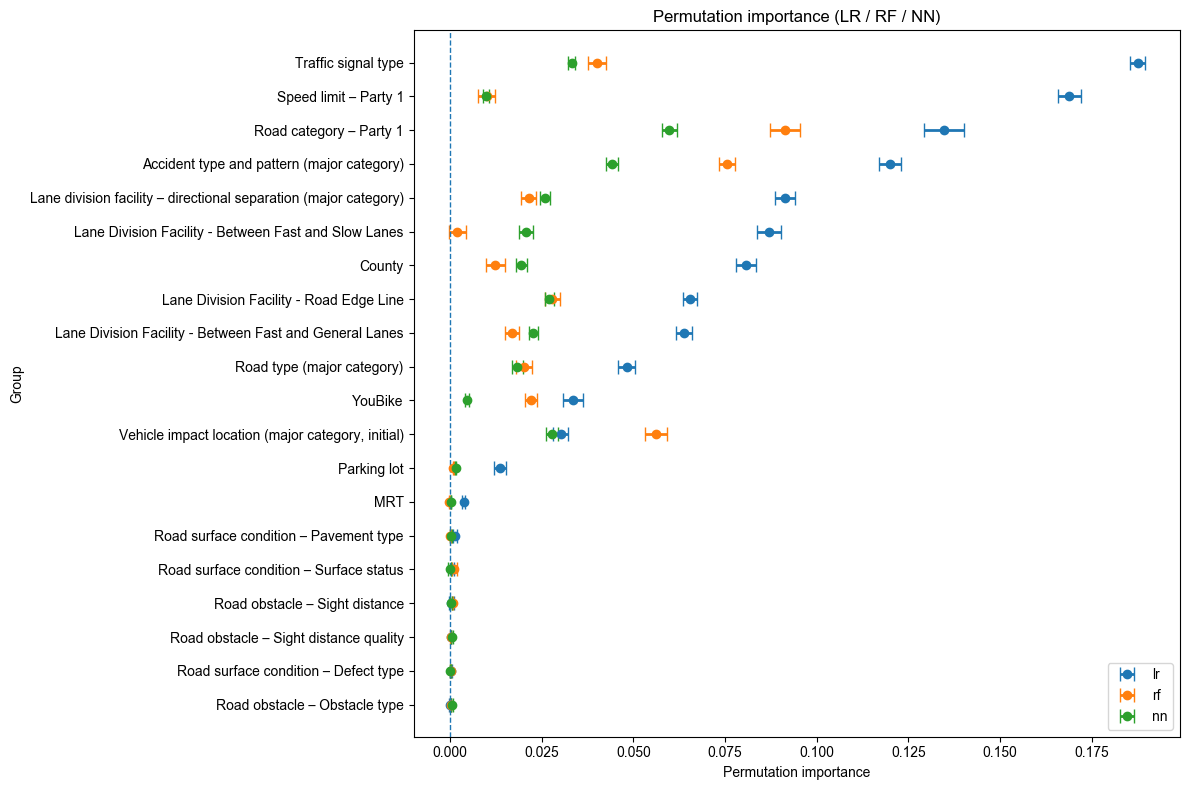

In [27]:
combined = pd.concat([
    perm_lr.assign(model='LR'),
    # perm_rf.assign(model='RF'),
    # perm_nn.assign(model='NN')
], ignore_index=True)

combined["group"] = combined["group"].map(group_translation)

order = (combined.groupby('group')['importance'].mean().sort_values(ascending=True).index.tolist())
ypos = np.arange(len(order))

triples = [
    (perm_lr, 'lr'), 
    (perm_rf, 'rf'), 
    (perm_nn, 'nn')
    ]

plt.figure(figsize=(12, 8))

for perm_df_i, name in triples:
    perm_df_i["group"] = perm_df_i["group"].map(group_translation)
    d = (perm_df_i.set_index('group').reindex(order)) # 用統一群組順序對齊
    plt.errorbar(
        d['importance'],
        (ypos),
        xerr=d['std'],
        fmt='o',
        linewidth=2,
        capsize=5,
        label=name
    )

plt.yticks(ypos, order)
plt.axvline(0.0, linestyle='--', linewidth=1)
plt.xlabel('Permutation importance')
plt.ylabel('Group')
plt.title('Permutation importance (LR / RF / NN)')
plt.legend()
plt.tight_layout()
plt.show()


# Hitrate

In [28]:
county_cols = [col for col in X_resampled_test.columns if col.startswith('county_')]


df_hitrate = X_resampled_test.copy()
df_hitrate['y_true'] = y_resampled_test
df_hitrate['y_pred'] = y_pred_lr

hitrate = {}
for col in county_cols:

    mask = df_hitrate[df_hitrate[col] != False]
    tn, fp, fn, tp = confusion_matrix(
        mask['y_true'], mask['y_pred'], labels=[0, 1]
    ).ravel()

    # calculate precision, recall, accuracy, f1-score
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    hitrate[col] = {
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy,
        'f1': f1
    }

hitrate_df = pd.DataFrame.from_dict(hitrate, orient='index', columns=['precision', 'recall', 'accuracy', 'f1']).sort_values('f1', ascending=False)
hitrate_df['county'] = hitrate_df.index
hitrate_df['county'] = hitrate_df['county'].str.replace('county_', '')

In [29]:
from utils_model import hitrate_data
# from config import countycity_dct

hitrate_lr = hitrate_data(X_resampled_test, y_resampled_test, y_pred_lr)
hitrate_rf = hitrate_data(X_resampled_test, y_resampled_test, y_pred_rf)
hitrate_nn = hitrate_data(X_resampled_test, y_resampled_test, test_metrics['pred_y'])

hitrate_lr['county'] = hitrate_lr['county'].map(countycity_dct)
hitrate_rf['county'] = hitrate_rf['county'].map(countycity_dct)
hitrate_nn['county'] = hitrate_nn['county'].map(countycity_dct)

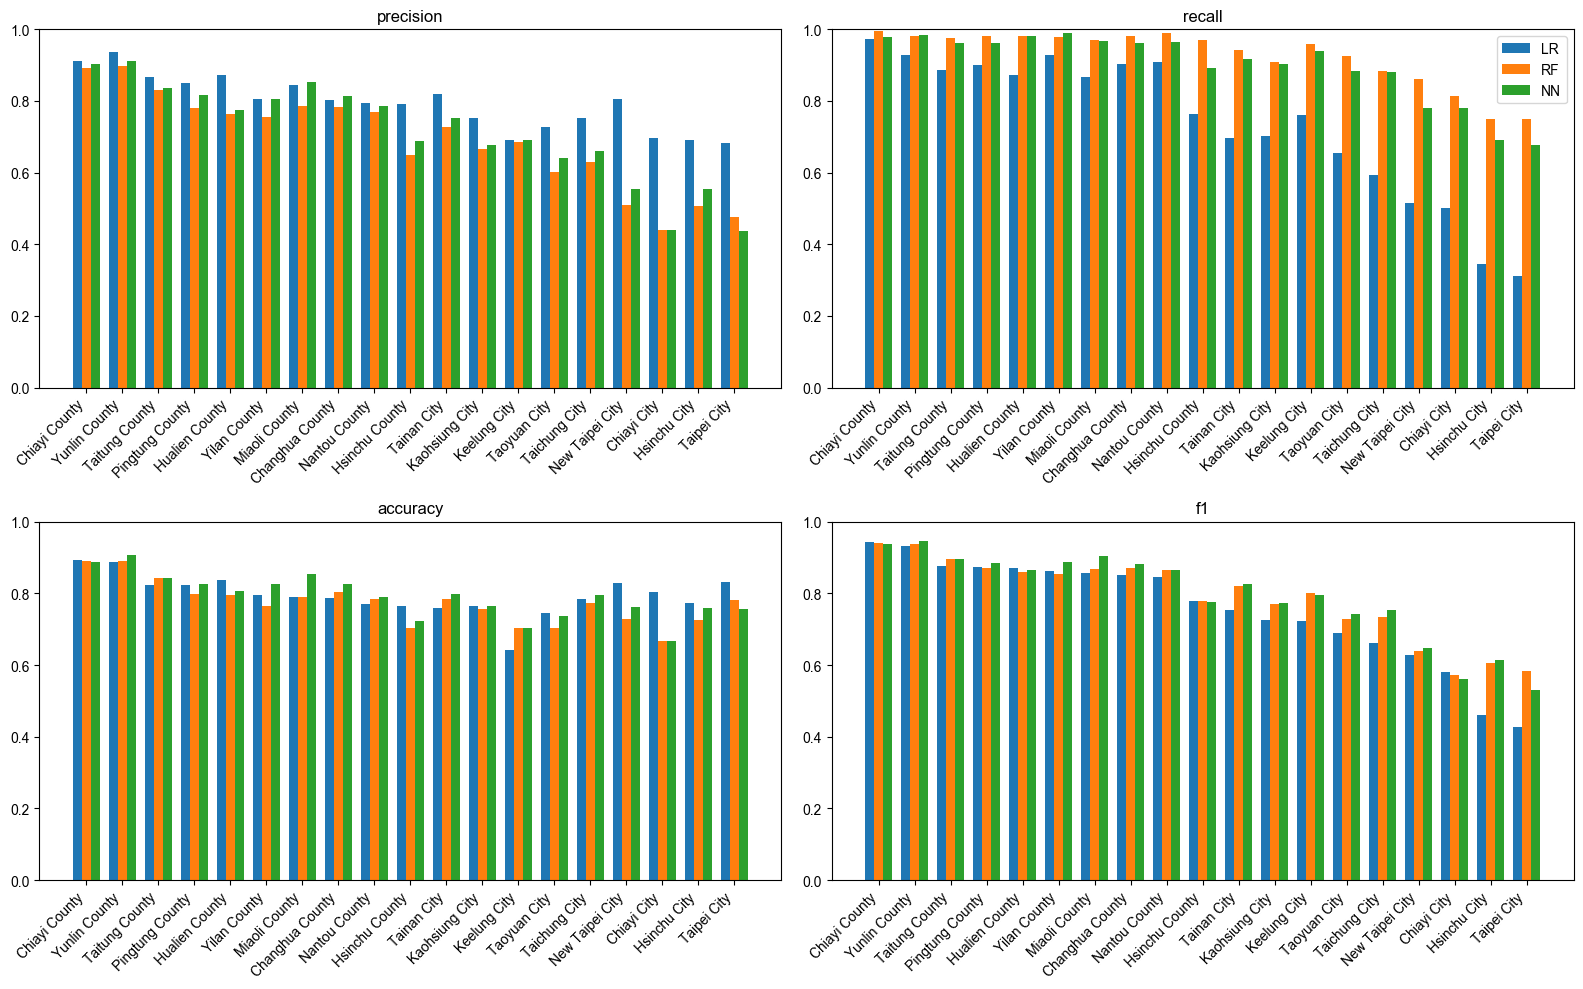

In [30]:
results = {
    'LR': hitrate_lr.copy(),
    'RF': hitrate_rf.copy(),
    'NN': hitrate_nn.copy(),
}
order = (results['LR'].sort_values('f1', ascending=False)['county']).tolist()

metrics = ['precision', 'recall', 'accuracy', 'f1']
plt.figure(figsize=(16, 10))

for i, met in enumerate(metrics, 1):
    ax = plt.subplot(2, 2, i)
    pos = np.arange(len(order))
    width = 0.25
    for j, (name, df) in enumerate(results.items()):
        d = df.set_index('county').reindex(order)
        ax.bar(pos + (j-1)*width, d[met].values, width=width, label=name)
    ax.set_title(met)
    ax.set_xticks(pos)
    ax.set_xticklabels(order, rotation=45, ha='right')
    if i == 2:
        ax.legend(loc='upper right')
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()


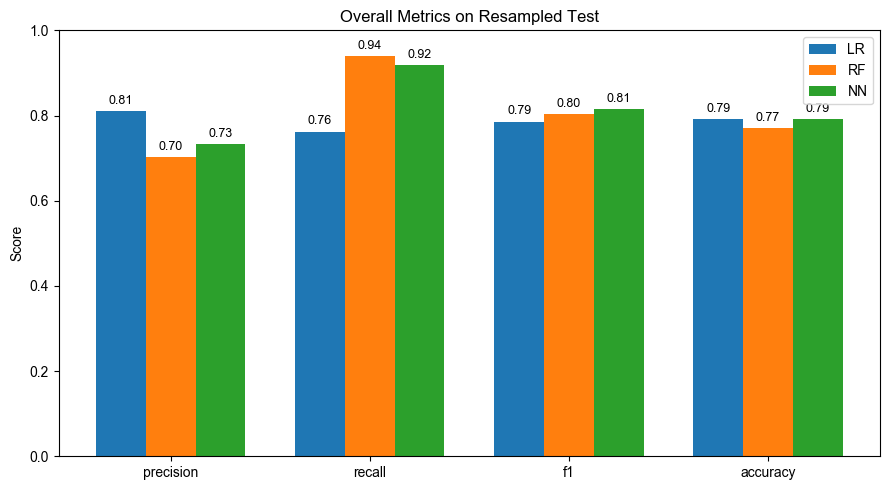

In [31]:
def metrics_bin(y_true, y_pred):
    return {
        'precision': precision_score(y_true, y_pred, pos_label=0),
        'recall':    recall_score(y_true, y_pred, pos_label=0),
        'f1':        f1_score(y_true, y_pred, pos_label=0),
        'accuracy':  accuracy_score(y_true, y_pred),
    }

m_lr = metrics_bin(y_resampled_test, y_pred_lr)
m_rf = metrics_bin(y_resampled_test, y_pred_rf)
m_nn = metrics_bin(y_resampled_test, test_metrics['pred_y'])

df = pd.DataFrame([m_lr, m_rf, m_nn], index=['LR','RF','NN'])
metrics = ['precision', 'recall', 'f1', 'accuracy']
df = df[metrics]

plt.figure(figsize=(9, 5))
x = np.arange(len(metrics))
width = 0.25

for i, model in enumerate(df.index):
    plt.bar(x + (i-1)*width, df.loc[model].values, width=width, label=model)

plt.xticks(x, metrics)
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('Overall Metrics on Resampled Test')
plt.legend(loc='upper right')

for i, model in enumerate(df.index):
    vals = df.loc[model].values
    for xi, v in zip(x + (i-1)*width, vals):
        plt.text(xi, v + 0.01, f'{v:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()